In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from tqdm import tqdm
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches

In [2]:
!pip install torch-summary
!pip install tqdm

In [18]:
filenames = os.listdir("E:\\JK\\Vt\\dataset_vit_1024\\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cluster':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'image': filenames,
    'labels': categories
    
})
df

,image,labels
0,cluster.1 (2).jpg,1
1,cluster.1.jpg,1
2,cluster.10 (2).jpg,1
3,cluster.10.jpg,1
4,cluster.104 (2).jpg,1
...,...,...
1789,non_cluster.97.jpg,0
1790,non_cluster.98 (2).jpg,0
1791,non_cluster.98.jpg,0
1792,non_cluster.99 (2).jpg,0


In [3]:
df.to_csv('file2.csv', index=False)

In [4]:
class ImagesDataProcess(Dataset):
    def __init__(self,csv_file,root_dir,tranform=None):
        self.annotation=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.tranform=tranform
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        img_path=os.path.join(self.root_dir,self.annotation.iloc[index,0])
        image=io.imread(img_path)
        #image=resize(image,(640,640),anti_aliasing=True)
        y_label=torch.tensor(int(self.annotation.iloc[index,1]))
        
        if self.tranform:
            image=self.tranform(image)
        return (image,y_label)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 16
num_epochs = 10
root_dir_path='E:\\JK\\Vt\\dataset_vit_1024\\train'
csv_file_path='E:\\JK\\Vt\\file2.csv'

In [7]:
dataset=ImagesDataProcess(
    csv_file=csv_file_path,
    root_dir=root_dir_path,
    tranform=transforms.ToTensor()
)


In [36]:
len(dataset)

1794

In [8]:
train_set, test_set = torch.utils.data.random_split(dataset, [1444,350])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


In [9]:
# Model
model = torchvision.models.googlenet(pretrained=True)
model.fc=nn.Sequential(
    nn.Linear(in_features=1024,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32,out_features=2,bias=True)
) 
model.to(device);
model

e:\JK\Vt\vt\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\JK\Vt\vt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
from torchsummary import summary
print(summary(model, (3, 250, 250)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
       BatchNorm2d-2         [-1, 64, 125, 125]             128
       BasicConv2d-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 62, 62]               0
            Conv2d-5           [-1, 64, 62, 62]           4,096
       BatchNorm2d-6           [-1, 64, 62, 62]             128
       BasicConv2d-7           [-1, 64, 62, 62]               0
            Conv2d-8          [-1, 192, 62, 62]         110,592
       BatchNorm2d-9          [-1, 192, 62, 62]             384
      BasicConv2d-10          [-1, 192, 62, 62]               0
        MaxPool2d-11          [-1, 192, 31, 31]               0
           Conv2d-12           [-1, 64, 31, 31]          12,288
      BatchNorm2d-13           [-1, 64, 31, 31]             128
      BasicConv2d-14           [-1, 64,

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")


0it [00:00, ?it/s]91it [49:13, 32.45s/it]


Cost at epoch 0 is 0.454668789774507


91it [48:56, 32.27s/it]


Cost at epoch 1 is 0.3902227691896669


91it [45:20, 29.89s/it]


Cost at epoch 2 is 0.3642985265661072


91it [44:10, 29.12s/it]


Cost at epoch 3 is 0.326246515243918


91it [44:25, 29.29s/it]


Cost at epoch 4 is 0.27231691245521816


91it [44:44, 29.50s/it]


Cost at epoch 5 is 0.280312311313637


91it [44:44, 29.50s/it]


Cost at epoch 6 is 0.23251744595120896


91it [44:45, 29.51s/it]


Cost at epoch 7 is 0.22737234765356715


91it [44:37, 29.43s/it]


Cost at epoch 8 is 0.22214616970210285


91it [44:46, 29.52s/it]

Cost at epoch 9 is 0.1614197050374779


In [13]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device,dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()
torch.save(model,'E:\\JK\\Vt\\model_full_1024.pth')

In [14]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Checking accuracy on Training Set


  0%|          | 0/91 [00:00<?, ?it/s]100%|██████████| 91/91 [18:20<00:00, 12.10s/it]


Got 1385 / 1444 with accuracy 95.91
Checking accuracy on Test Set


100%|██████████| 22/22 [04:32<00:00, 12.41s/it]

Got 306 / 350 with accuracy 87.43


In [36]:
torch.save(model.state_dict(),'E:\\JK\\Vt\\model_dict.pth')

In [37]:
torch.save(model,'E:\\JK\\Vt\\model_full.pth')

In [1]:
the_model = torch.load('E:\\JK\\Vt\\model_full.pth')
the_model.eval

NameError: name 'torch' is not defined

In [2]:
print("Checking accuracy on Train set")
check_accuracy(test_loader, the_model)

Checking accuracy on Train set


NameError: name 'check_accuracy' is not defined

In [3]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

        # Calculate and display the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    model.train()

Checking accuracy on Test Set


100%|██████████| 22/22 [04:30<00:00, 12.31s/it]


Got 306 / 350 with accuracy 87.43


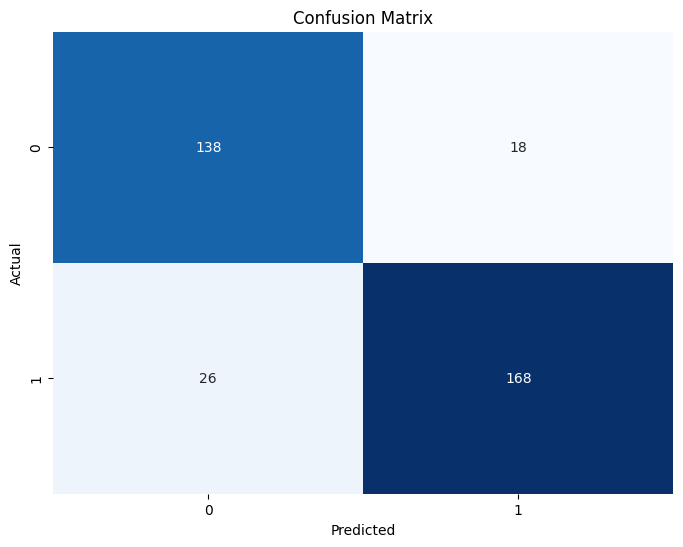

In [17]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

In [25]:
from PIL import Image
import torchvision.transforms as transforms
img = Image.open('E:\\JK\\Vt\\non_cluster.17.jpg')
transform=transforms.ToTensor()
tensor = transform(img)
model(tensor.unsqueeze(0))

tensor([[-1.4285,  2.5908]], grad_fn=<AddmmBackward0>)

In [27]:
import torch
from torchvision import transforms
from PIL import Image

# Load and preprocess the image
image_path = 'E:\\JK\\Vt\\cluster.1.jpg'
image = Image.open(image_path)

# Define the transformation to apply to the image
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize the image to match the input size of the model
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Apply the transformation to the image
input_image = transform(image).unsqueeze(0)

# Load the pre-trained model
#model = torch.load('/content/model_full.pth')
model.eval()  # Set the model to evaluation mode

# Make predictions
with torch.no_grad():
    output = model(input_image)
    probabilities = torch.sigmoid(output)  # Apply sigmoid activation to get probabilities
    #threshold = 0.5  # Set the threshold for binary classification
    #predictions = (probabilities > threshold).int()  # Convert probabilities to binary predictions

# Print the predictions
print('probabilities',probabilities)

probabilities tensor([[0.4097, 0.6689]])


In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image



# Load the image and preprocess
def preprocess_image(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((1024, 1024)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
    return input_batch

# Make predictions
def predict_image(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        return predicted_class, probabilities

# Example usage
# image_path = 'E:\\JK\\Vt\\12.jpg'
#input_tensor = preprocess_image(image_path)
#predicted_class, class_probabilities = predict_image(model, input_tensor)
#print(predicted_class)

In [7]:
#!pip install gradio_hdrimage

In [12]:
#DEMO

In [4]:
import torch
model = torch.load('E:\\Vt\\model_full_1024.pth')
model.eval

<bound method Module.eval of GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, mom

In [5]:
import torch
import cv2
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Make predictions
def predict_image(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        if predicted_class ==0:
           img = cv2.imread('E:\\Vt\\out_non_cluster.jpg')
           return img
        if predicted_class ==1:
           img = cv2.imread('E:\\Vt\\out_cluster.jpg')
           return img 


# Load the image and preprocess
def preprocess_image(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((1024, 1024)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
    image=predict_image(model,input_batch)
    return image


           


#input_tensor = preprocess_image(image_path)
#predicted_class, class_probabilities = predict_image(model, input_tensor)
#print(predicted_class)


In [6]:
import gradio as gr
from gradio_hdrimage import HDRImage
#example = HDRImage().example_inputs()

demo = gr.Interface(
    fn=preprocess_image, inputs="file", outputs="image",title="AI BASED CERVICAL IMAGE ANALYSIS FOR HPV DETECTION",
   
# Custom CSS with clear selectors and comments
css = """
.gradio-container {
background: url(https://upload.wikimedia.org/wikipedia/commons/4/49/Abstract_-_Coconut_Leaf_%28Imagicity_186%29.jpg)
}
.gr.description{
    font-size:50px;
    color:white;
}

h1 {
    text-align: center;
    display:block;
    color:white;
    font-size:50px;
}


"""


    
    #lambda x:x,
    #HDRImage(),  # interactive version of your component
    #HDRImage(),  # static version of your component
     #examples=[[example]],  # uncomment this line to view the "example version" of your component
) 
 


if __name__ == "__main__":
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://9cf6ecca125dcd9ec8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
